In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
import itertools
from collections import defaultdict
import time
from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torchvision import datasets, transforms, utils
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen
import snntorch.spikeplot as splt
import math

torch.manual_seed(42)
np.random.seed(42)
#print(torch.cuda.is_available())

data_path = '\\Users\\liamh\\OneDrive - University of Strathclyde\\University'
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
### For Image purposes, the dataloader is set to not shuffle the images

batch_size = 128
def load_in_data(res, ratio = 1):
    transform = transforms.Compose([
        transforms.Resize((res, res)), #Resize images to 28*28
        transforms.Grayscale(), # Make sure image is grayscale
        transforms.ToTensor()]) # change each image array to a tensor which automatically scales inputs to [0,1]

    mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform) # Download training set and apply transformations. 
    mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform) # same for test set

    train_len = int(len(mnist_train)/ratio)
    dummy_len = len(mnist_train) - train_len
    train_dataset, _ = random_split(mnist_train, (train_len, dummy_len), generator=torch.Generator().manual_seed(42))
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # Load the data into the DataLoader so it's passed through the model, shuffled in batches. 
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)
    
    return train_loader, test_loader

def plot_all_training_histories(model_df, model_title = 'ANN'):
    fig, axs = plt.subplots(2, 2, figsize = (20,12))
    plt.suptitle(f'All {model_title} Test Accuracies', fontsize = 22)
    axs[0,0].plot(model_df['output_56_r1_valid_accuracy'], label = '100% data')
    axs[0,0].plot(model_df['output_56_r4_valid_accuracy'], label = '25% data')
    axs[0,0].plot(model_df['output_56_r10_valid_accuracy'], label = '10% data')
    axs[0,0].plot(model_df['output_56_r100_valid_accuracy'], label = '1% data')
    axs[0,0].yaxis.set_major_formatter(PercentFormatter(100))
    axs[0,0].set_title('56x56 resolution models', fontsize = 18)
    axs[0,0].set_xlabel('Epoch',fontsize = 14)
    axs[0,0].legend()

    axs[0,1].plot(model_df['output_28_r1_valid_accuracy'], label = '100% data')
    axs[0,1].plot(model_df['output_28_r4_valid_accuracy'], label = '25% data')
    axs[0,1].plot(model_df['output_28_r10_valid_accuracy'], label = '10% data')
    axs[0,1].plot(model_df['output_28_r100_valid_accuracy'], label = '1% data')
    axs[0,1].yaxis.set_major_formatter(PercentFormatter(100))
    axs[0,1].set_xlabel('Epoch',fontsize = 14)
    axs[0,1].set_title('28x28 resolution models',fontsize = 18)
    axs[0,1].legend()

    axs[1,0].plot(model_df['output_14_r1_valid_accuracy'], label = '100% data')
    axs[1,0].plot(model_df['output_14_r4_valid_accuracy'], label = '25% data')
    axs[1,0].plot(model_df['output_14_r10_valid_accuracy'], label = '10% data')
    axs[1,0].plot(model_df['output_14_r100_valid_accuracy'], label = '1% data')
    axs[1,0].set_title('14x14 resolution models', fontsize = 18)
    axs[1,0].set_xlabel('Epoch',fontsize = 14)
    axs[1,0].yaxis.set_major_formatter(PercentFormatter(100))
    axs[1,0].legend()

    axs[1,1].plot(model_df['output_7_r1_valid_accuracy'], label = '100% data')
    axs[1,1].plot(model_df['output_7_r4_valid_accuracy'], label = '25% data')
    axs[1,1].plot(model_df['output_7_r10_valid_accuracy'], label = '10% data')
    axs[1,1].plot(model_df['output_7_r100_valid_accuracy'], label = '1% data')
    axs[1,1].set_title('7x7 resolution models', fontsize = 18)
    axs[1,1].set_xlabel('Epoch',fontsize = 14)
    axs[1,1].yaxis.set_major_formatter(PercentFormatter(100))
    axs[1,1].legend()
    

In [3]:
ann_results = pd.read_csv('all_simple_ann_training_histories_final.csv',index_col = 0)
rate_snn_results = pd.read_csv('all_simple_rate_snn_training_histories_final.csv',index_col = 0)
latency_snn_results = pd.read_csv('all_simple_latency_snn_training_histories_final.csv',index_col = 0)
cnn_results = pd.read_csv('all_cnn_training_histories_final.csv',index_col = 0)
scnn_results = pd.read_csv('all_scnn_training_histories_final.csv',index_col = 0)

In [4]:
ann_df = pd.DataFrame()
for column in ann_results.columns:
    if 'valid_accuracy' in column:
        ann_df[column] = ann_results[column]
        
rate_snn_df = pd.DataFrame()
for column in rate_snn_results.columns:
    if 'valid_accuracy' in column:
        rate_snn_df[column] = rate_snn_results[column]
        
latency_snn_df = pd.DataFrame()
for column in latency_snn_results.columns:
    if 'valid_accuracy' in column:
        latency_snn_df[column] = latency_snn_results[column]
        
cnn_df = pd.DataFrame()
for column in cnn_results.columns:
    if 'valid_accuracy' in column:
        cnn_df[column] = cnn_results[column]
        
scnn_df = pd.DataFrame()
for column in scnn_results.columns:
    if 'valid_accuracy' in column:
        scnn_df[column] = scnn_results[column]

# Training Histories

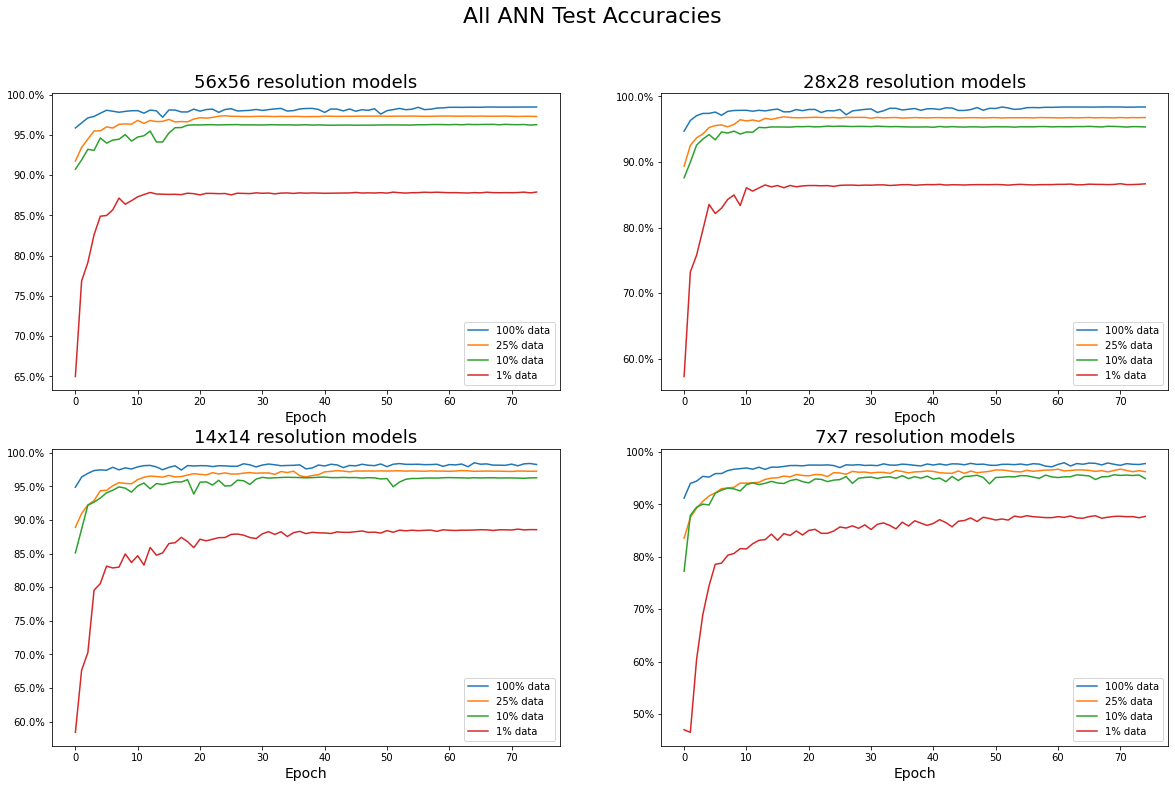

In [44]:
plot_all_training_histories(ann_df, model_title = 'ANN')

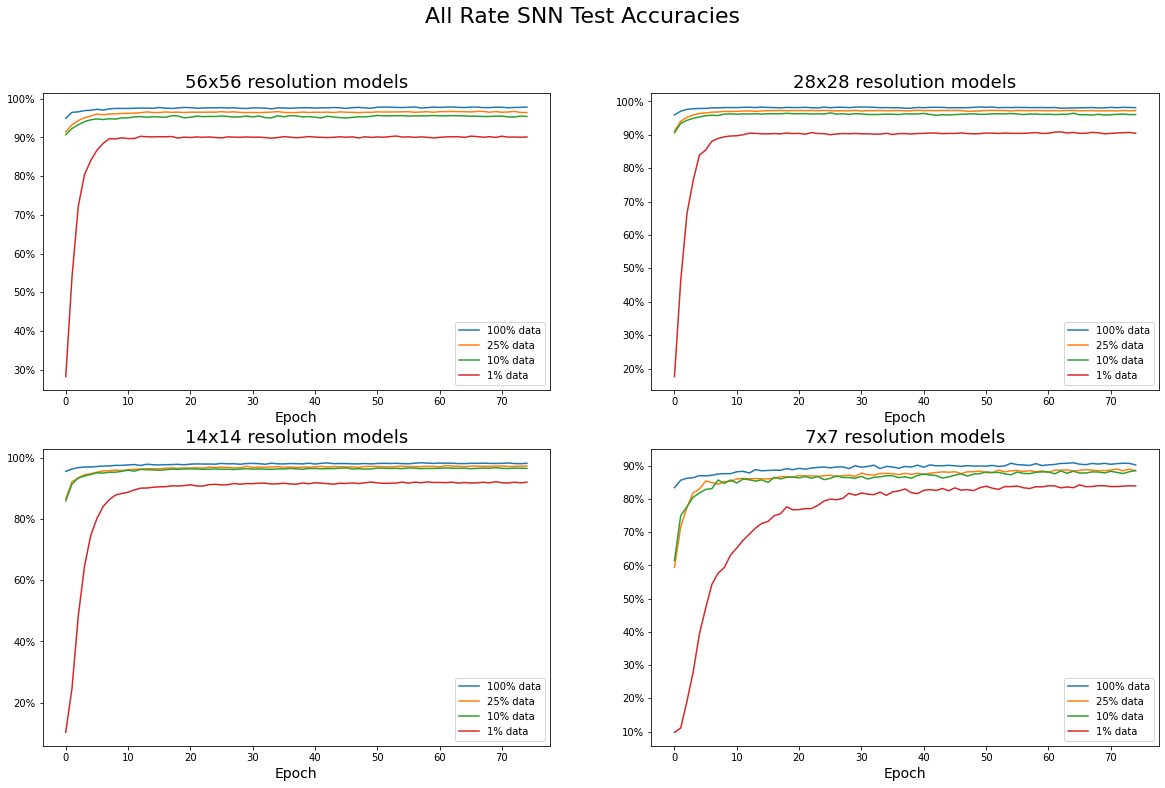

In [6]:
plot_all_training_histories(rate_snn_df, model_title = 'Rate SNN')

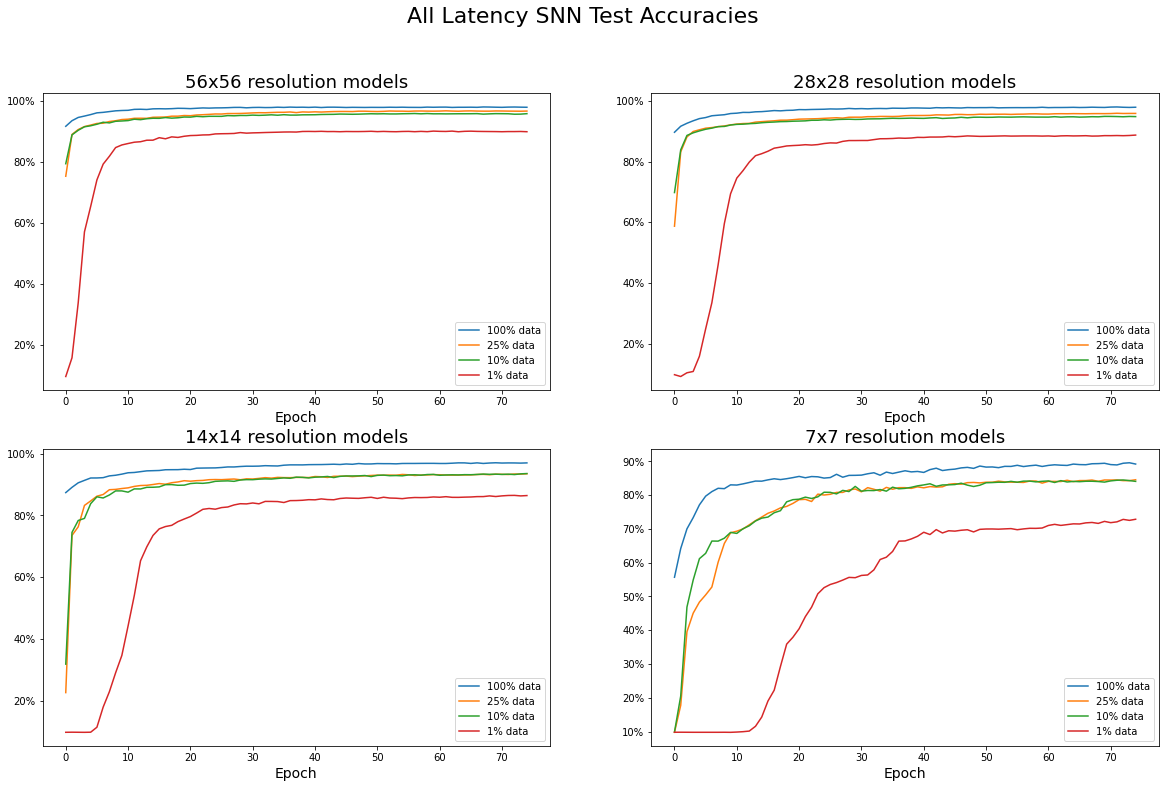

In [7]:
plot_all_training_histories(latency_snn_df, model_title = 'Latency SNN')

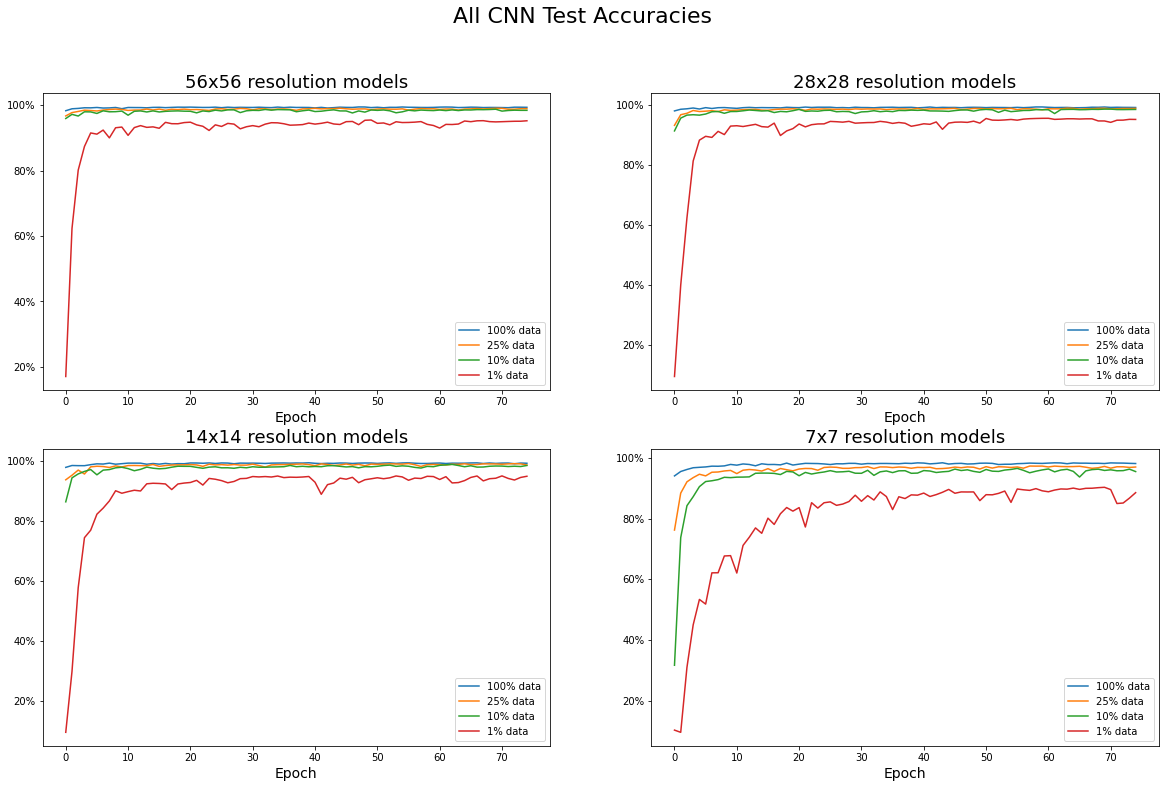

In [8]:
plot_all_training_histories(cnn_df, model_title = 'CNN')

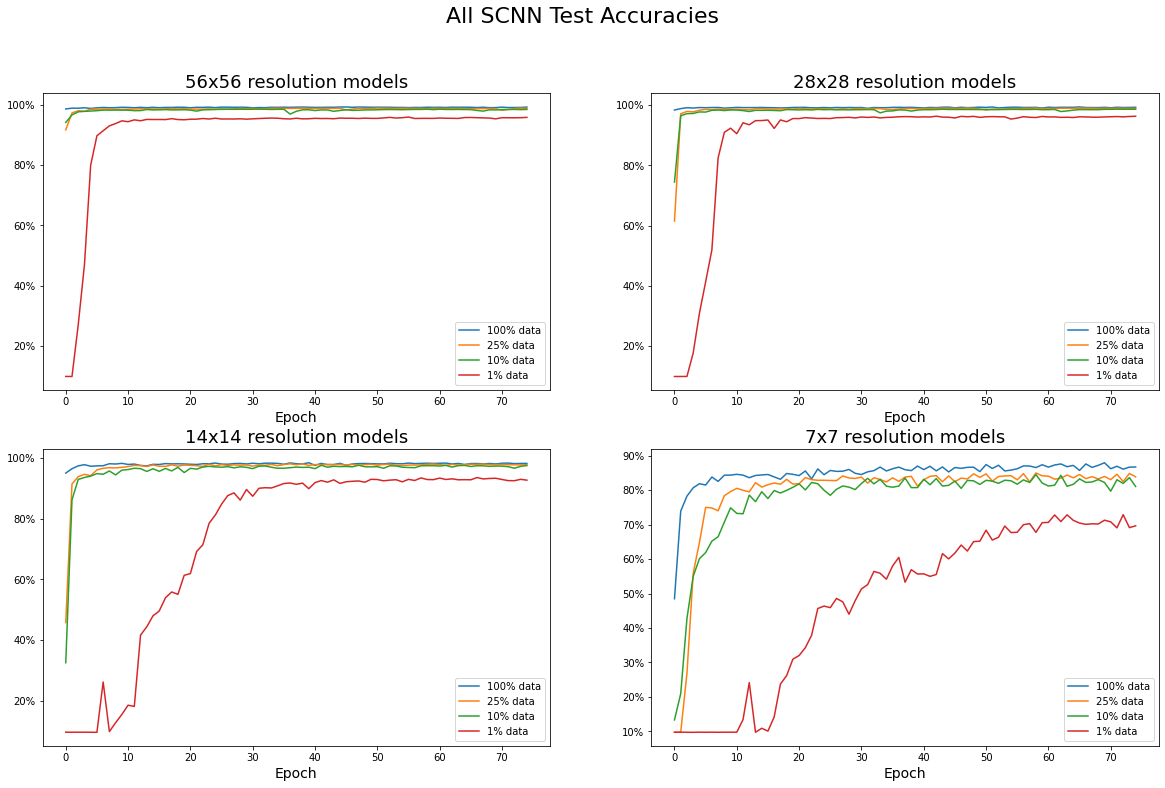

In [9]:
plot_all_training_histories(scnn_df, model_title = 'SCNN')

# Plotting the distribution of instances for subsets

In [10]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for _,j in dataloader_obj:
        y_idx = j.item()
        y_lbl = idx2class[y_idx]
        count_dict[str(y_lbl)] += 1
            
    return count_dict

In [13]:
res = 28
transform = transforms.Compose([
    transforms.Resize((res, res)), #Resize images to 28*28
    transforms.Grayscale(), # Make sure image is grayscale
    transforms.ToTensor() ])# change each image array to a tensor

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform) # Download training set and apply transformations. 
#mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform) # same for test set

idx2class = {v: k for k, v in mnist_train.class_to_idx.items()}


print("Distribution of classes: \n", get_class_distribution(mnist_train))

train_len = int(len(mnist_train)/100)
test_len = len(mnist_train) - train_len

train_len = int(len(mnist_train)/100)
test_len = len(mnist_train) - train_len
train_dataset, test_dataset = random_split(mnist_train, (train_len, test_len), generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

Distribution of classes: 
 {'0 - zero': 5923, '1 - one': 6742, '2 - two': 5958, '3 - three': 6131, '4 - four': 5842, '5 - five': 5421, '6 - six': 5918, '7 - seven': 6265, '8 - eight': 5851, '9 - nine': 5949}


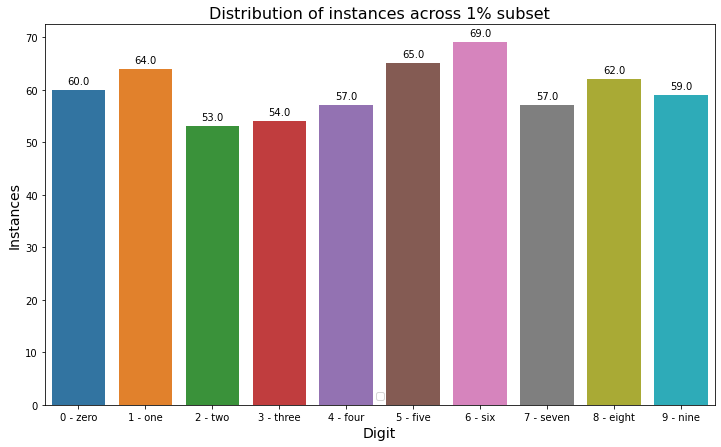

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,7))
splot = sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_loaders(train_loader, mnist_train)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes, dodge = False)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',fontsize = 10)
plt.title('Distribution of instances across 1% subset',fontsize = 16)
axes.set_ylabel('Instances',fontsize = 14)
axes.set_xlabel('Digit',fontsize = 14)
axes.legend([],[])
plt.show()

# Visualisation for different MNIST digits

In [22]:
res_56, _ = load_in_data(56, 1)
res_28, _ = load_in_data(28, 1)
res_14, _ = load_in_data(14, 1)
res_7,  _ = load_in_data(7,  1)

im56, l56 = next(iter(res_56))
im28, l28 = next(iter(res_28))
im14, l14 = next(iter(res_14))
im7, l7 = next(iter(res_7))

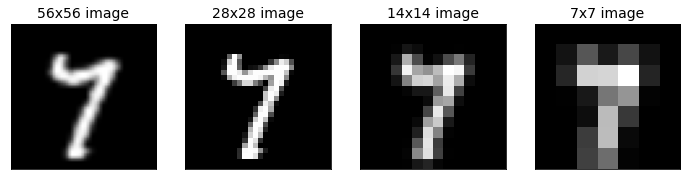

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(12, 8))
axs[0].imshow(im56[1].permute(1, 2, 0), cmap = 'gray')
axs[1].imshow(im28[1].permute(1, 2, 0), cmap = 'gray')
axs[2].imshow(im14[1].permute(1, 2, 0), cmap = 'gray')
axs[3].imshow(im7[1].permute(1, 2, 0), cmap = 'gray')

axs[0].set_title('56x56 image', fontsize = 14)
axs[1].set_title('28x28 image', fontsize = 14)
axs[2].set_title('14x14 image', fontsize = 14)
axs[3].set_title('7x7 image', fontsize = 14)

    
for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
plt.savefig('MnistImagesres.png')
plt.show()

# Plots showing encoded images at different time steps

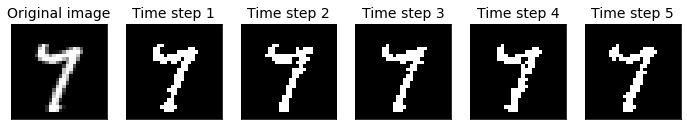

In [54]:
train, _ = load_in_data(28, 1)
x,y = next(iter(train))
x_rate = spikegen.rate(x, num_steps=25, gain=1, offset=0)
spike_data_sample = x_rate[:, 1, -1]

fig, axs = plt.subplots(1, 6, figsize=(12, 8))
axs[0].imshow(x[1,-1], cmap = 'gray')
axs[1].imshow(spike_data_sample[0], cmap = 'gray')
axs[2].imshow(spike_data_sample[1], cmap = 'gray')
axs[3].imshow(spike_data_sample[2], cmap = 'gray')
axs[4].imshow(spike_data_sample[3], cmap = 'gray')
axs[5].imshow(spike_data_sample[4], cmap = 'gray')

axs[0].set_title('Original image', fontsize = 14)

for i in range(1,6):
    axs[i].set_title(f'Time step {i}', fontsize = 14)
    
for i in range(6):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
plt.savefig('MnistImages.png')
plt.show()

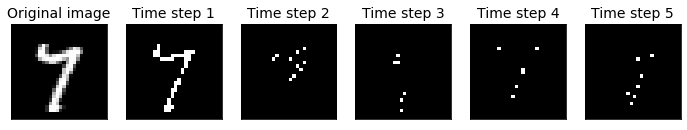

In [55]:
x_latency =  spikegen.latency(x, num_steps=25, tau=15, threshold=0.1, linear = True)
spike_data_sample_latency = x_latency[:, 1, -1]

fig, axs = plt.subplots(1, 6, figsize=(12, 8))
axs[0].imshow(x[1,-1], cmap = 'gray')
axs[1].imshow(spike_data_sample_latency[0], cmap = 'gray')
axs[2].imshow(spike_data_sample_latency[1], cmap = 'gray')
axs[3].imshow(spike_data_sample_latency[2], cmap = 'gray')
axs[4].imshow(spike_data_sample_latency[3], cmap = 'gray')
axs[5].imshow(spike_data_sample_latency[4], cmap = 'gray')

axs[0].set_title('Original image', fontsize = 14)

for i in range(1,6):
    axs[i].set_title(f'Time step {i}', fontsize = 14)
    
for i in range(6):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
plt.savefig('MnistImageslatency.png')
plt.show()

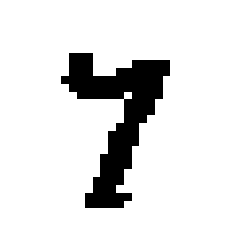

In [56]:
plt.imshow(spike_data_sample_latency[14], cmap = 'gray')
plt.axis('off')
#plt.title('final time step of latency encoding')
plt.show()

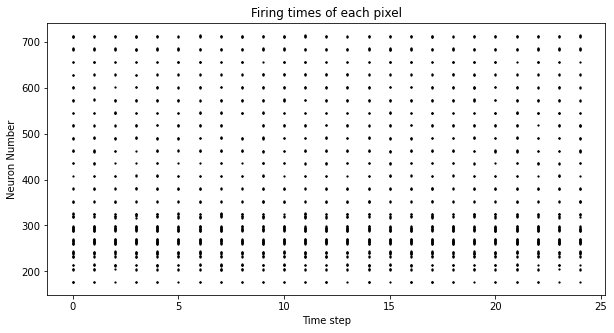

In [50]:
#spike_data = spikegen.latency(x, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(x_rate[:, 1].view(25, -1), ax, s=1.5, c="black")
plt.title("Firing times of each pixel")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

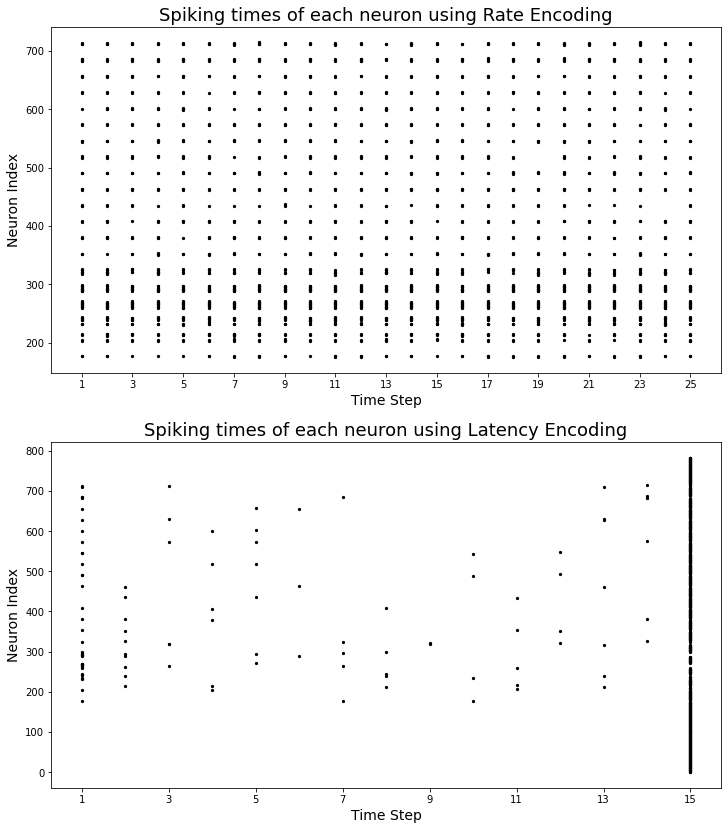

In [107]:
fig, axs = plt.subplots(2,1, figsize=(12, 14))
splt.raster(x_rate[:, 1].view(25, -1), axs[0], s=5, c="black")
splt.raster(x_latency[:, 1].view(25, -1), axs[1], s=5, c="black")
axs[0].set_title('Spiking times of each neuron using Rate Encoding',fontsize = 18)
axs[1].set_title('Spiking times of each neuron using Latency Encoding',fontsize = 18)

axs[0].set_ylabel('Neuron Index',fontsize = 14)
axs[1].set_ylabel('Neuron Index',fontsize = 14)

axs[0].set_xlabel('Time Step',fontsize = 14)
axs[1].set_xlabel('Time Step',fontsize = 14)

axs[0].xaxis.set_major_formatter(plt.FuncFormatter(func_formater))
axs[0].set_xticks(range(0,26,2))

axs[1].xaxis.set_major_formatter(plt.FuncFormatter(func_formater))
axs[1].set_xticks(range(0,15,2))

plt.show()

# ReLu Plot

In [120]:
def ReLu(x):
    relu = max(0,x)
    
    return relu

inputs = [x for x in range(-10,11)]
outputs = [ReLu(x) for x in inputs]

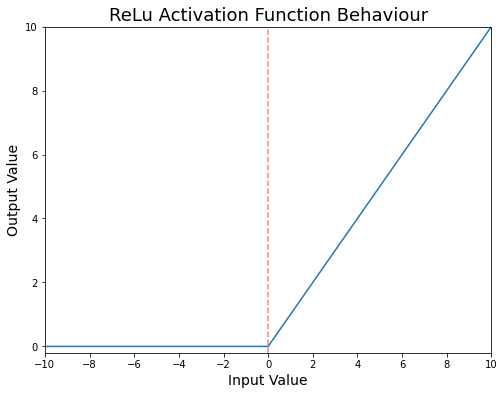

In [171]:
plt.figure(figsize=(8, 6))
plt.plot(inputs,outputs)
plt.axvline(x=0, alpha = 0.5, c = 'red',linestyle = '--')
plt.xticks(range(-10,11,2))
plt.xlabel('Input Value', fontsize = 14)
plt.ylabel('Output Value', fontsize = 14)
plt.title('ReLu Activation Function Behaviour', fontsize = 18)
plt.xlim(-10,10)
plt.ylim(-0.2,10)
plt.show()


# Loose Code

In [ ]:
def plot_training_history(history, res, loss_upper = 1.05, acc_lower = -0.05, acc_higher = 105):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    
    ax1.plot(history['avg_train_loss'], label='train loss',marker = 'o')
    ax1.plot(history['avg_valid_loss'], label='validation loss',marker = 'o')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, loss_upper])
    ax1.legend()
    ax1.set_ylabel('Loss',fontsize = 16)
    ax1.set_xlabel('Epoch',fontsize = 16)
    
    ax2.plot(history['train_accuracy'], label='train accuracy',marker = 'o')
    ax2.plot(history['valid_accuracy'], label='validation accuracy',marker = 'o')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([acc_lower, acc_higher])

    ax2.legend()

    ax2.set_ylabel('Accuracy',fontsize = 16)
    ax2.yaxis.set_major_formatter(PercentFormatter(100))
    ax2.set_xlabel('Epoch',fontsize = 16)
    fig.suptitle(f'Training history ({res}*{res})',fontsize = 20)
    plt.show()

In [30]:
ann_df.iloc[[-1]]

,output_56_r1_valid_accuracy,output_56_r4_valid_accuracy,output_56_r10_valid_accuracy,output_56_r100_valid_accuracy,output_28_r1_valid_accuracy,output_28_r4_valid_accuracy,output_28_r10_valid_accuracy,output_28_r100_valid_accuracy,output_14_r1_valid_accuracy,output_14_r4_valid_accuracy,output_14_r10_valid_accuracy,output_14_r100_valid_accuracy,output_7_r1_valid_accuracy,output_7_r4_valid_accuracy,output_7_r10_valid_accuracy,output_7_r100_valid_accuracy
74,98.57,97.5,96.09,88.27,98.39,96.79,95.58,86.76,98.52,97.23,96.32,88.12,97.92,96.54,95.68,87.1


In [78]:
ann_56_valid_accuracy = ann_df.iloc[[-1],[0,1,2,3]]

In [84]:
ann_56_valid_accuracy.iloc[0]

output_56_r1_valid_accuracy      98.57
output_56_r4_valid_accuracy      97.50
output_56_r10_valid_accuracy     96.09
output_56_r100_valid_accuracy    88.27
Name: 74, dtype: float64

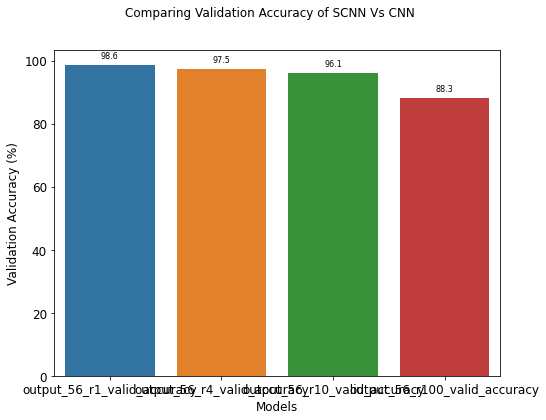

In [95]:
plt.figure(figsize=(8, 6))
splot = sns.barplot(x=ann_56_valid_accuracy.columns, y=ann_56_valid_accuracy.iloc[0])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',fontsize = 8)
plt.xlabel('Models',fontsize = 12)
plt.ylabel('Validation Accuracy (%)',fontsize = 12)
#plt.title('Same network architecture and shared params.\nx% indicates percentage of training data used',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.suptitle('Comparing Validation Accuracy of SCNN Vs CNN',fontsize=12)

plt.show()